In [1]:
%matplotlib inline

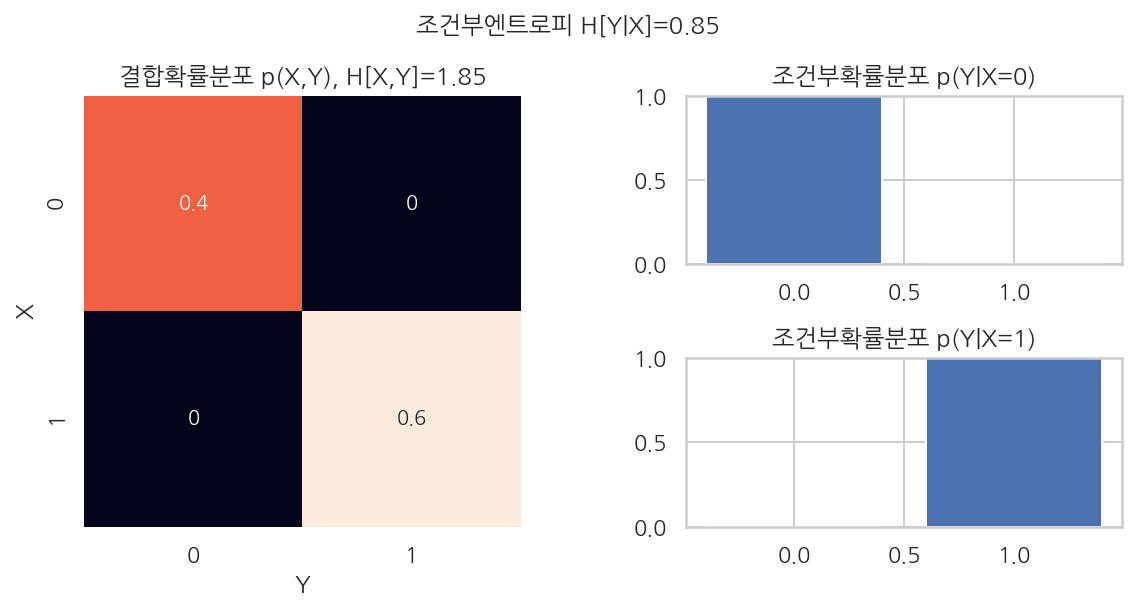

In [2]:
# 예측에 도움이 되는 경우
plt.figure(figsize = (8, 4), facecolor = "1.")
ax1 = plt.subplot(121)
pXY = [[0.4, 0], [0, 0.6]]
sns.heatmap(pXY, annot=True, cbar=False)
plt.xlabel("Y")
plt.ylabel("X")
plt.title("결합확률분포 p(X,Y), H[X,Y]=1.85")

plt.subplot(222)
plt.bar([0, 1], [1, 0])
plt.ylim(0, 1)
plt.title("조건부확률분포 p(Y|X=0)")

plt.subplot(224)
plt.bar([0, 1], [0, 1])
plt.ylim(0, 1)
plt.title("조건부확률분포 p(Y|X=1)")

plt.tight_layout(w_pad=5)
plt.suptitle("조건부엔트로피 H[Y|X]=0.85", y=1.05)
plt.show()

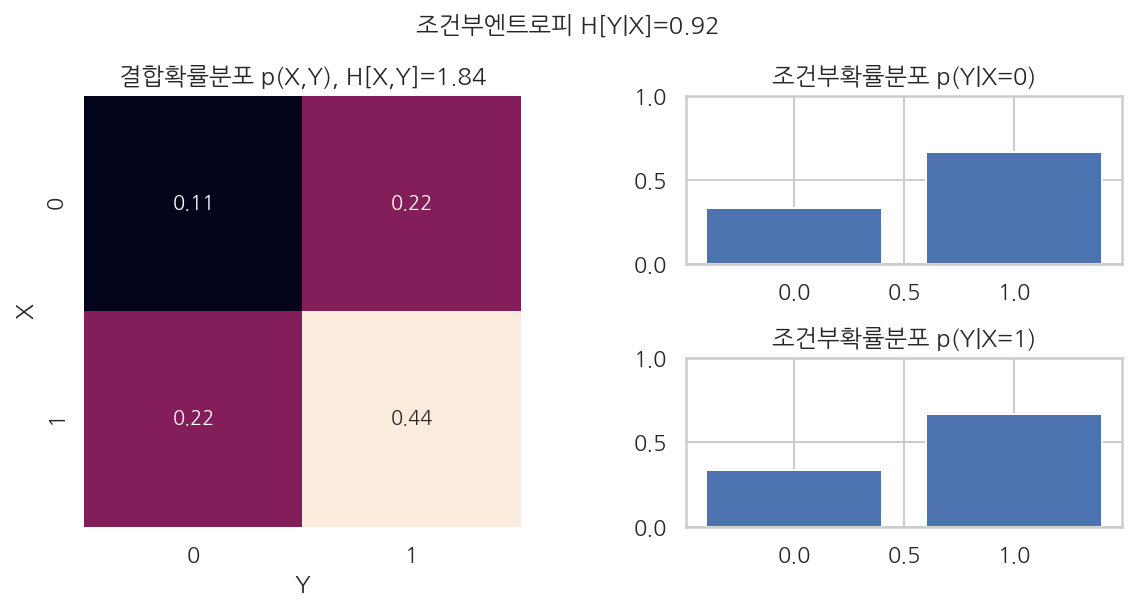

In [3]:
# 예측에 도움이 되지않는 경우
plt.figure(figsize=(8, 4), facecolor="1.")
ax1 = plt.subplot(121)
pXY = [[1/9, 2/9], [2/9, 4/9]]
sns.heatmap(pXY, annot=True, cbar=False)
plt.xlabel("Y")
plt.ylabel("X")
plt.title("결합확률분포 p(X,Y), H[X,Y]=1.84")

plt.subplot(222)
plt.bar([0, 1], [1/3, 2/3])
plt.ylim(0, 1)
plt.title("조건부확률분포 p(Y|X=0)")

plt.subplot(224)
plt.bar([0, 1], [1/3, 2/3])
plt.ylim(0, 1)
plt.title("조건부확률분포 p(Y|X=1)")

plt.tight_layout(w_pad=5)
plt.suptitle("조건부엔트로피 H[Y|X]=0.92", y=1.05)
plt.show()

In [4]:
from sklearn.datasets import load_iris

iris = load_iris()
idx = np.in1d(iris.target, [1, 2])
X = iris.data[idx, :]
y = iris.target[idx]
df = pd.DataFrame(X, columns=iris.feature_names)
df["species"] = iris.target[idx]
df.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
95,6.7,3.0,5.2,2.3,2
96,6.3,2.5,5.0,1.9,2
97,6.5,3.0,5.2,2.0,2
98,6.2,3.4,5.4,2.3,2
99,5.9,3.0,5.1,1.8,2


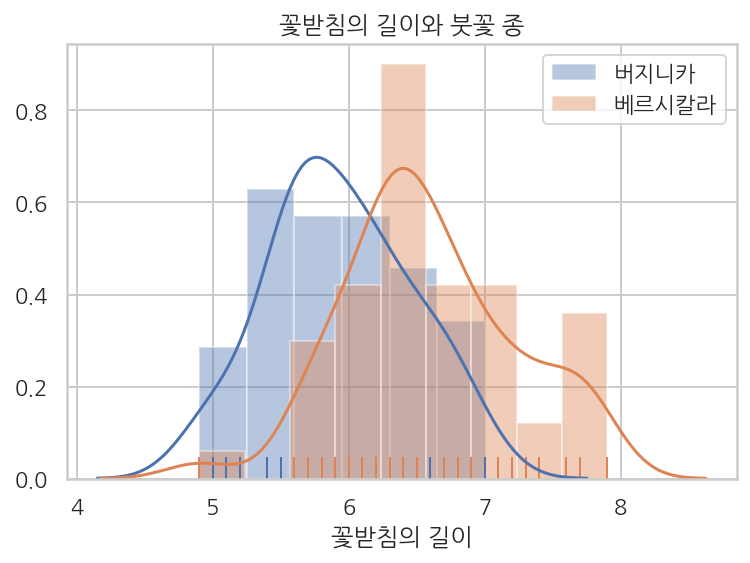

In [5]:
plt.figure(facecolor="1.")
sns.distplot(df[df.species == 1]["sepal length (cm)"], hist=True, rug=True, label="버지니카")
sns.distplot(df[df.species == 2]["sepal length (cm)"], hist=True, rug=True, label="베르시칼라")
plt.legend()
plt.xlabel("꽃받침의 길이")
plt.title("꽃받침의 길이와 붓꽃 종")
plt.show()

# 꽃받침의 길이가 크면 베르시칼라 길이가 작으면 버지니카 -> 대략적인 정보
# 분류문제에서 명시적이고 수치적인 기준 -> 기준값을 어디로 잡는가?
# 